### Objective
To visually examine the relationship between currency in circulation and the tradition of exchanging lucky money during the chinese new year for good luck.


Gifts and visits are exchanged among friends and relatives and children receive lai see, or ‘lucky money’. See more about the tradition:
https://www.gov.hk/en/about/abouthk/factsheets/docs/religion.pdf

### Preparing CNY dates data
https://www.travelchinaguide.com/essential/holidays/new-year/dates.htm

In [1]:
import pandas as pd
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

url = 'https://www.travelchinaguide.com/essential/holidays/new-year/dates.htm'
html = requests.get(url).content
df_list = pd.read_html(html)
CNY = df_list[-1]
CNY['New Year Dates'] = CNY['New Year Dates'].str.replace('\([A-Za-z]*\)','')
CNY['New Year Dates'] = pd.to_datetime(CNY['New Year Dates'])
CNY['Years']=CNY['Years'].apply(str)
CNY = CNY.drop(range(0,82))
CNY = CNY.drop(range(92,101))



### HKMA data

In [2]:
from dateutil.relativedelta import *
url = 'https://api.hkma.gov.hk/public/market-data-and-statistics/monthly-statistical-bulletin/money/supply-components-hkd'
response = requests.get(url)
json = response.json()


data2 = pd.DataFrame(json['result']['records'])
data2=data2.rename(columns = {'legal_tender_notes_coins_in_pub':'notes_coins_in_pub'})
def add_month(x):
    return x+relativedelta(months=1)
data2['date'] = pd.to_datetime(data2['end_of_month']).apply(add_month)
data2['Year'] = data2['end_of_month'].apply(lambda x: x[:4])




### Adjusting for inflation
data source: https://www.censtatd.gov.hk/en/web_table.html?id=52#

In [3]:
infl = pd.read_csv('Table 52.csv')
infl.columns = ['Year','Month','CPI Index']
infl = infl.drop(range(0,13))
infl = infl.drop(range(121,139))
infl['date'] = pd.to_datetime(infl['Year'] + '-' + infl['Month'])
infl['date'] = infl['date'].apply(add_month)


### Merging dataframes

In [4]:
merge1 = pd.merge(infl, data2, how = 'right', on = 'date')
merge1=merge1[['CPI Index', 'date','notes_coins_in_pub','Year_x']]
merge1['notes_coins_in_pub'] = pd.to_numeric(merge1['notes_coins_in_pub'])
merge1['CPI Index'] = pd.to_numeric(merge1['CPI Index'])
merge1['inflation_adjusted_n&c'] = (merge1['notes_coins_in_pub']*102.2)/merge1['CPI Index']

merge2 = pd.merge(merge1, CNY, how = 'right', left_on = 'Year_x', right_on = 'Years')
merge2 = merge2.groupby(by = 'New Year Dates')['inflation_adjusted_n&c'].mean().reset_index()
merge2 = merge2.drop(0)


### Plotting

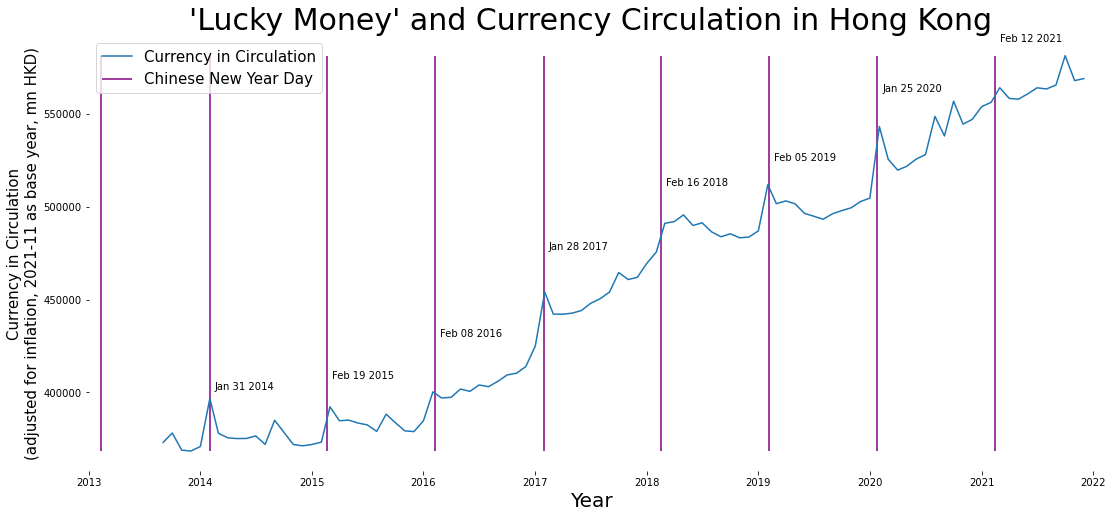

In [6]:
plt.figure(figsize = (18,8))

x = merge1['date']
y = merge1['inflation_adjusted_n&c']

plt.plot(x, y, label = 'Currency in Circulation')
plt.title("'Lucky Money' and Currency Circulation in Hong Kong", fontsize = 30)
plt.ylabel('Currency in Circulation\n(adjusted for inflation, 2021-11 as base year, mn HKD)', fontsize = 15)
plt.xlabel('Year', fontsize = 20)


plt.vlines(CNY['New Year Dates'], ymin = min(y), ymax = max(y),
           colors = 'purple', label = 'Chinese New Year Day')

plt.legend(fontsize = 15)

for x, y in zip(merge2['New Year Dates'][1:], merge2['inflation_adjusted_n&c'][1:]):
    plt.annotate(x.strftime("%b %d %Y"), 
            (x, y), 
            textcoords="offset points", 
            xytext=(5,45), 
            ha='left',
            fontsize = 10);
    
plt.xlim(datetime(2013,1,1),datetime(2022,1,1))

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

